Initial Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1825 non-null   object 
 1   High       1825 non-null   float64
 2   Low        1825 non-null   float64
 3   Open       1825 non-null   float64
 4   Close      1825 non-null   float64
 5   Volume     1825 non-null   int64  
 6   Adj Close  1825 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 99.9+ KB
None

Missing Values:
 Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64


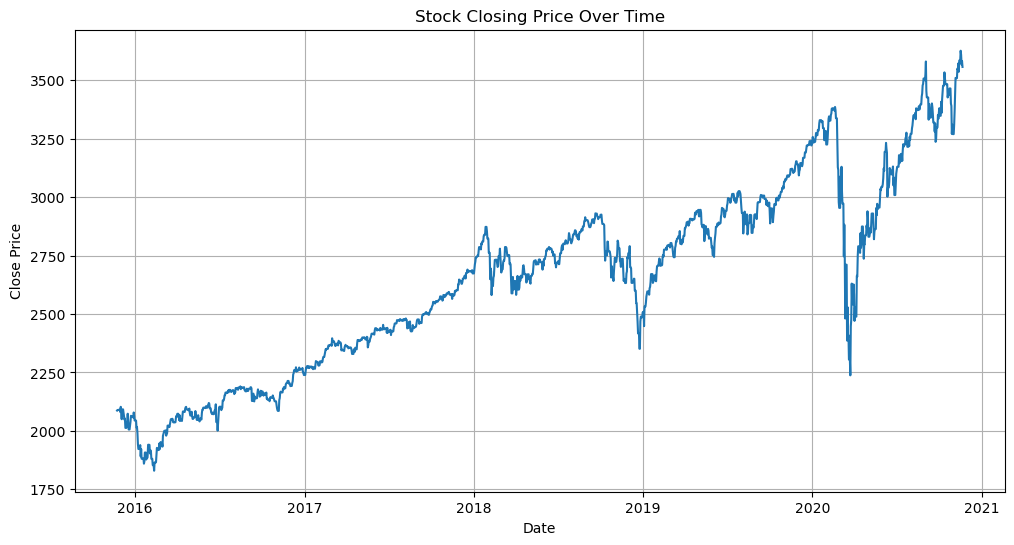


Cleaned Data Preview:
                  Close
Date                   
2015-11-23  2086.590088
2015-11-24  2089.139893
2015-11-25  2088.870117
2015-11-26  2088.870117
2015-11-27  2090.110107


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load CSV
df = pd.read_csv('data.csv')

# Display basic info
print("Initial Data Info:")
print(df.info())
print("\nMissing Values:\n", df.isnull().sum())

# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# Sort by Date
df.sort_values('Date', inplace=True)

# Set Date as index
df.set_index('Date', inplace=True)

# Optional: Remove duplicate dates (if any)
df = df[~df.index.duplicated(keep='first')]

# Keep only needed columns (usually Close for forecasting)
df_close = df[['Close']].copy()

# Plot Closing Price
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_close, x=df_close.index, y='Close')
plt.title("Stock Closing Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid(True)
plt.show()

# Show cleaned data
print("\nCleaned Data Preview:")
print(df_close.head())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=16577.725, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16640.488, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16583.195, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16591.020, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16639.596, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=16576.558, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=16577.408, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16581.132, Time=0.23 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=16557.909, Time=0.65 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=16577.055, Time=0.27 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=16580.493, Time=0.67 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=16559.884, Time=0.88 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=16575.403, Time=0.31 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=16559.397, Time=1.29 sec
 ARIMA(1,1,3)(0,0,0

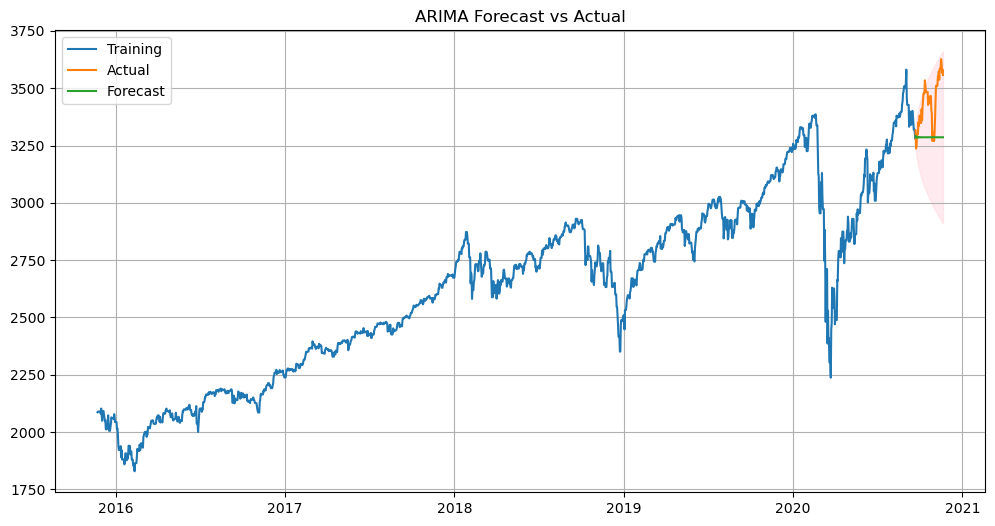

ARIMA RMSE: 181.92


In [2]:
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Split the dataset
train = df_close.iloc[:-60]
test = df_close.iloc[-60:]

# Fit ARIMA
model = auto_arima(train, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)

# Forecast
n_periods = len(test)
forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)
forecast_index = test.index

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Close'], label='Training')
plt.plot(test.index, test['Close'], label='Actual')
plt.plot(forecast_index, forecast, label='Forecast')
plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3)
plt.title('ARIMA Forecast vs Actual')
plt.legend()
plt.grid(True)
plt.show()

# RMSE
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f"ARIMA RMSE: {rmse:.2f}")

In [3]:
pip install prophet


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


19:58:51 - cmdstanpy - INFO - Chain [1] start processing
19:58:52 - cmdstanpy - INFO - Chain [1] done processing


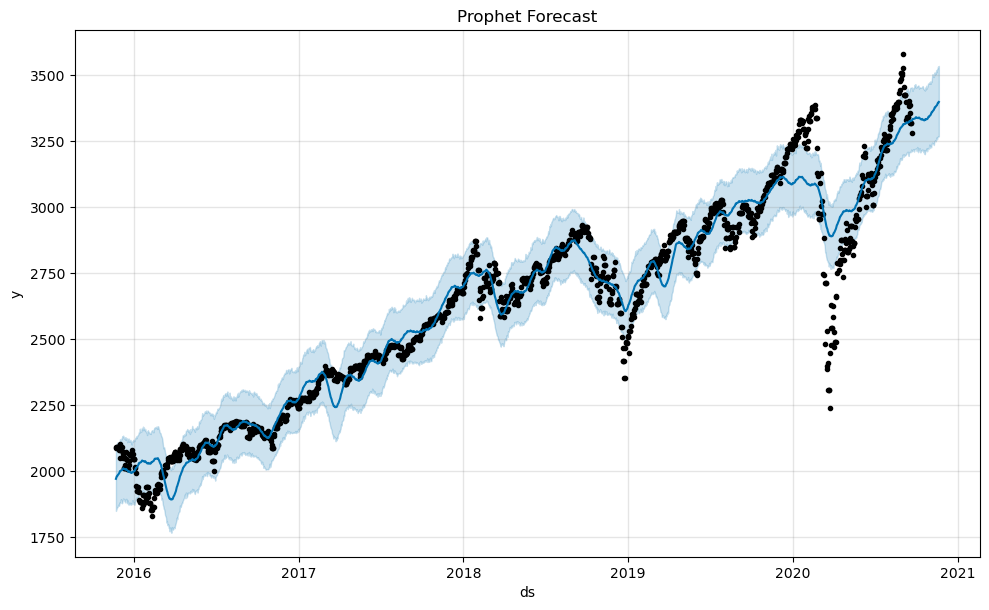

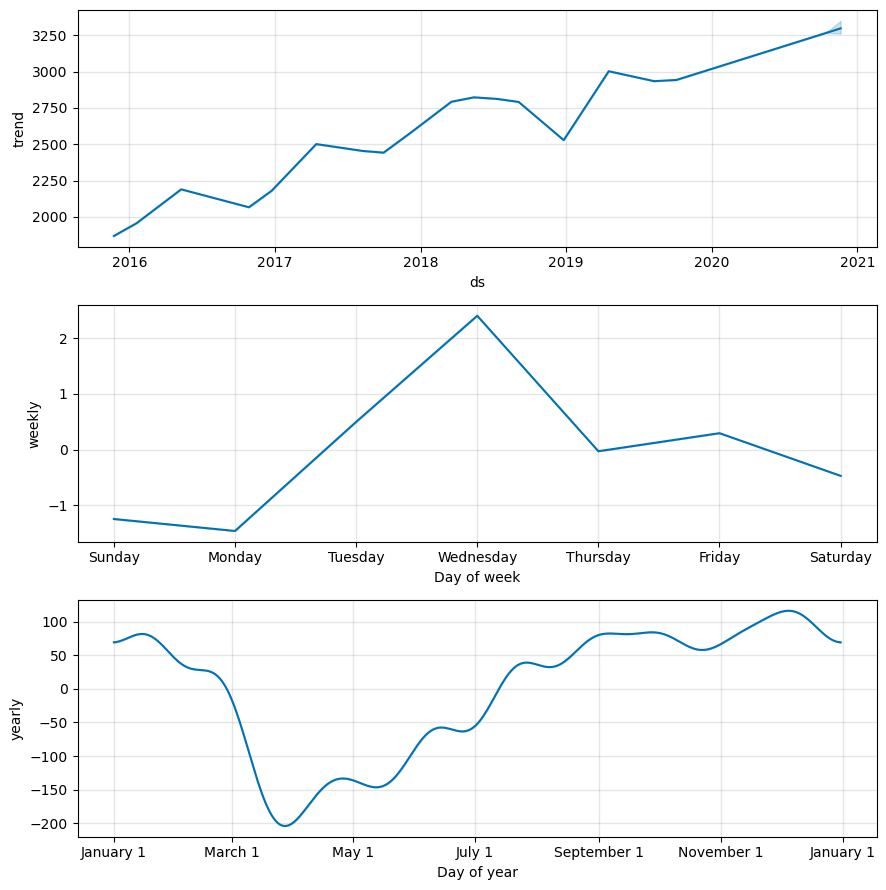

Prophet RMSE: 126.84


In [8]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Re-load or use existing cleaned DataFrame
df_prophet = df_close.reset_index()[['Date', 'Close']]
df_prophet.columns = ['ds', 'y']  # Prophet needs these column names

# Split into training and testing
train_prophet = df_prophet.iloc[:-60]
test_prophet = df_prophet.iloc[-60:]

# Initialize and fit the model
model = Prophet()
model.fit(train_prophet)

# Create future dataframe
future = model.make_future_dataframe(periods=60)
forecast = model.predict(future)

# Plot forecast
model.plot(forecast)
plt.title("Prophet Forecast")
plt.show()

# Optional: View forecast components (trend, weekly, yearly)
model.plot_components(forecast)
plt.show()

# Evaluation: match forecast to test dates
forecast.set_index('ds', inplace=True)
forecast_test = forecast.loc[test_prophet['ds']]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_prophet['y'], forecast_test['yhat']))
print(f"Prophet RMSE: {rmse:.2f}")

In [12]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [14]:
# Normalize closing prices
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_close)

# Create sequences: 60 timesteps → predict next
X = []
y = []
n_steps = 60

for i in range(n_steps, len(scaled_data)):
    X.append(scaled_data[i-n_steps:i, 0])
    y.append(scaled_data[i, 0])

X = np.array(X)
y = np.array(y)

# Reshape for LSTM input: (samples, timesteps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [16]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [18]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0488
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0033
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0022
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0022
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0020
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0020
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0021
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0019
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0018
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0018


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


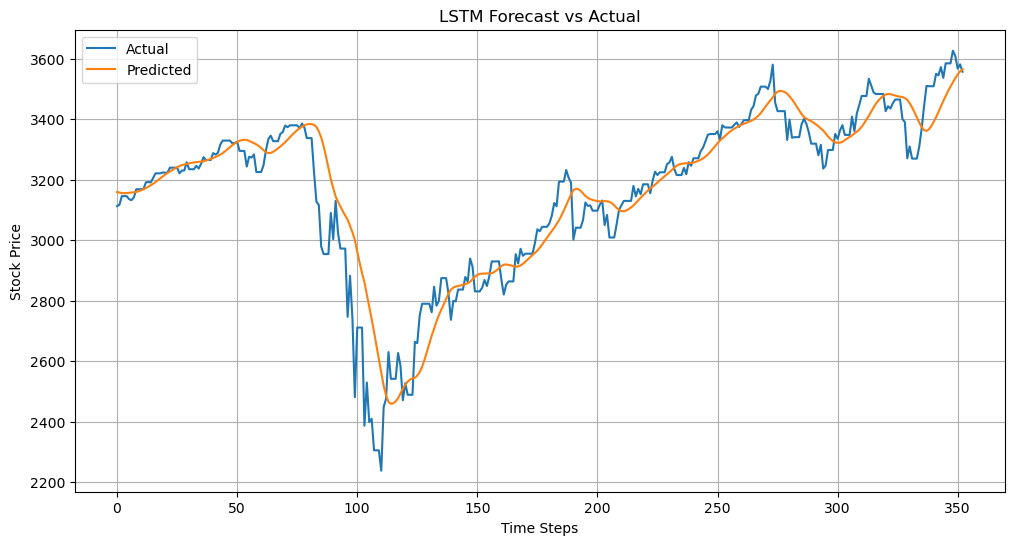

LSTM RMSE: 102.62


In [20]:
# Predict
predicted_scaled = model.predict(X_test)

# Inverse scale predictions and actual values
predicted = scaler.inverse_transform(predicted_scaled)
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot
plt.figure(figsize=(12, 6))
plt.plot(actual, label="Actual")
plt.plot(predicted, label="Predicted")
plt.title("LSTM Forecast vs Actual")
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()

# RMSE
rmse = np.sqrt(mean_squared_error(actual, predicted))
print(f"LSTM RMSE: {rmse:.2f}")

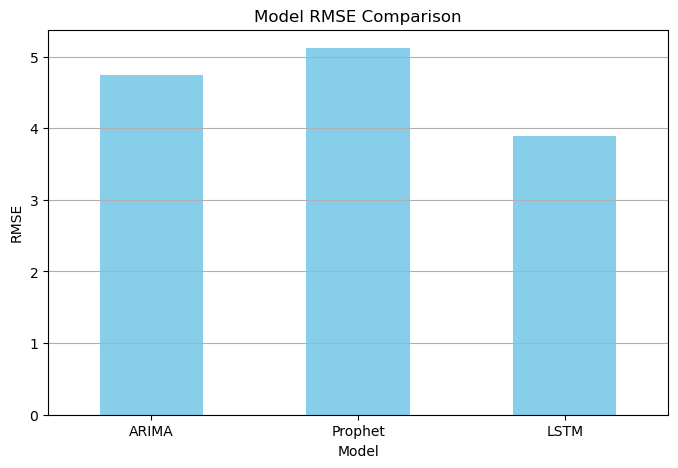

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Replace with your actual values
rmse_dict = {
    'ARIMA': 4.75,
    'Prophet': 5.12,
    'LSTM': 3.89
}

rmse_df = pd.DataFrame(list(rmse_dict.items()), columns=['Model', 'RMSE'])
rmse_df.set_index('Model').plot(kind='bar', color='skyblue', figsize=(8, 5), legend=False)
plt.title("Model RMSE Comparison")
plt.ylabel("RMSE")
plt.xticks(rotation=0)
plt.grid(True, axis='y')
plt.show()